# Mohr's circles for a triaxial test
#### The following was prepared for my Engineering Geology independent study. It has not been reviewed. 

Mohr-Coulomb Failure Envelope from Triaxial Test Data
-----------------------------------------------------

This script analyzes results from a **triaxial compression test**, a common laboratory method used 
in geotechnical engineering and rock mechanics to determine the shear strength parameters of soil 
or rock samples.

In a triaxial test, cylindrical samples are subjected to a known **confining pressure** (σ₃) 
and then compressed axially until failure, recording the **axial stress at failure** (σ₁). 
The shear and normal stresses acting on potential failure planes are used to construct 
**Mohr's circles** representing the stress state at failure for each test.

By finding a **common tangent line** to the Mohr circles, we estimate the **Mohr-Coulomb 
failure envelope**:

    τ = c + σ * tan(θ)

Where:
- **τ** is the shear stress at failure
- **σ** is the normal stress
- **c** is the **cohesion intercept** (shear strength at zero normal stress)
- **θ** is the **friction angle**, representing material resistance to sliding

In this script:
- We compute Mohr circles for three triaxial tests (including unconfined compression).
- We generate candidate tangent lines and find the set most similar in intercept.
- We average these to determine the best-fit failure envelope.
- Only **positive slope tangents** are considered, corresponding to physically meaningful friction angles.

This envelope is essential for predicting failure in soil and rock masses and is widely used 
in slope stability, tunnel design, foundation analysis, and more.

Best average slope: 0.5411 (θ = 28.42°)
Best average intercept (c): 2.54e+00 Pa


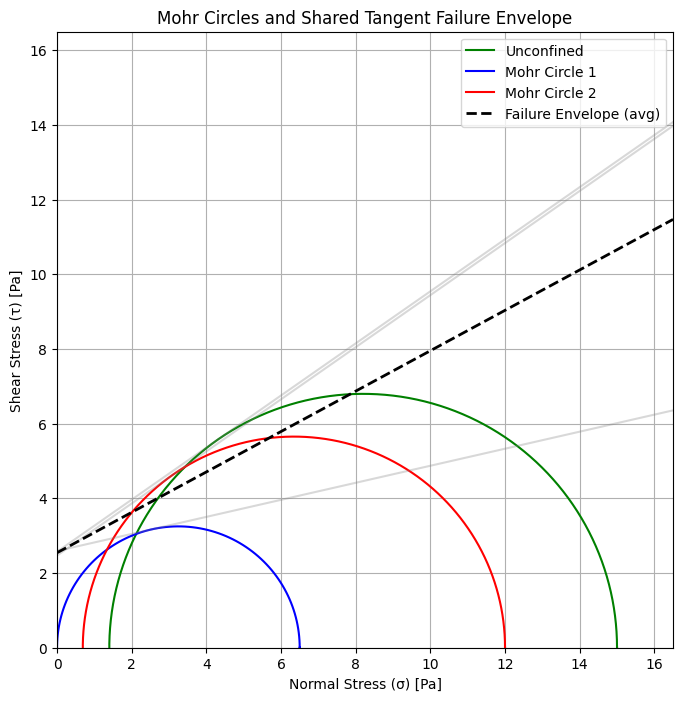

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from math import atan, degrees

# Given test data
cp1, asf1 = 0, 6.5
cp2, asf2 = 0.69, 12
cp0, asfu = 1.4, 15

# Circle centers and radii
centers = [(cp0 + asfu)/2, (cp1 + asf1)/2, (cp2 + asf2)/2]
radii = [(asfu - cp0)/2, (asf1 - cp1)/2, (asf2 - cp2)/2]
colors = ['g', 'b', 'r']
labels = ['Unconfined', 'Mohr Circle 1', 'Mohr Circle 2']

# Generate tangents
n_points = 50
theta = np.linspace(0, 2*np.pi, n_points)
tangent_lines = []

for center, radius in zip(centers, radii):
    lines = []
    for angle in theta:
        x = center + radius * np.cos(angle)
        y = radius * np.sin(angle)
        # Tangent slope at (x, y) on circle: perpendicular to radius
        dx = x - center
        dy = y
        if abs(dy) < 1e-6:  # dy ~ 0 leads to vertical tangent → skip
            continue
        m = -dx / dy
        b = y - m * x
        lines.append((m, b))
    tangent_lines.append(lines)

# Search for best-matching set of tangents
min_std = float('inf')
best_triplet = None

ranges = [range(len(tangent_lines[0])), range(len(tangent_lines[1])), range(len(tangent_lines[2]))]

for i, j, k in product(*ranges):
    try:
        m0, b0 = tangent_lines[0][i]
        m1, b1 = tangent_lines[1][j]
        m2, b2 = tangent_lines[2][k]
    except IndexError:
        continue

    slopes = [m0, m1, m2]
    intercepts = [b0, b1, b2]

    # Only include lines with valid and positive slopes
    if any(m <= 0 or not np.isfinite(m) for m in slopes):
        continue

    std_b = np.std(intercepts)  # match by intercept similarity

    if std_b < min_std:
        min_std = std_b
        best_triplet = [(m0, b0), (m1, b1), (m2, b2)]
        
# Average slope and intercept for the envelope
avg_m = np.mean([m for m, b in best_triplet])
avg_b = np.mean([b for m, b in best_triplet])
theta_deg = degrees(np.arctan(avg_m))

print(f"Best average slope: {avg_m:.4f} (θ = {theta_deg:.2f}°)")
print(f"Best average intercept (c): {avg_b:.2e} Pa")

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
angle_full = np.linspace(0, 2 * np.pi, 200)

# Draw Mohr circles
for center, radius, color, label in zip(centers, radii, colors, labels):
    x = center + radius * np.cos(angle_full)
    y = radius * np.sin(angle_full)
    ax.plot(x, y, color=color, label=label)

# Plot tangent lines of best triplet
for m, b in best_triplet:
    xs = np.linspace(0, max(asf1, asf2, asfu) * 1.1, 100)
    ys = m * xs + b
    ax.plot(xs, ys, 'gray', alpha=0.3)

# Final averaged failure envelope
tau_fit = avg_m * xs + avg_b
ax.plot(xs, tau_fit, 'k--', linewidth=2, label='Failure Envelope (avg)')

# Formatting
ax.set_xlim(0, max(asf1, asf2, asfu) * 1.1)
ax.set_ylim(0, max(asf1, asf2, asfu) * 1.1)
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('Normal Stress (σ) [Pa]')
ax.set_ylabel('Shear Stress (τ) [Pa]')
ax.set_title("Mohr Circles and Shared Tangent Failure Envelope")
ax.legend()
ax.grid(True)

plt.show()
